In [1]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
annotation=doc['annotation']


In [2]:
tss_annotation = doc['tss_annotation']

In [3]:

import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm
### notebook specific configuration ###
from os.path import basename
#mpl.style.use('ggplot')
mpl.style.use('fivethirtyeight')
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

from Modules.Homer import *

print('Number of tissues: ',len(tissues))

('Number of tissues: ', 16)


In [4]:
## Bio import
from Bio import motifs as mt
from Bio.Seq import Seq
from Bio import SeqIO

### Convert homer motifs into pfm format

In [2]:
for i in glob.glob("supplemental/homer_motifs/*motif"):
    curr = pd.read_csv(i,sep='\t',comment='>',header=None)
    curr = curr.transpose()
    curr.to_csv(i + ".pfm",sep='\t',index=None,header=None)

### Functions to take in fa file and motif file and convert into dictionary where each key is a fasta id and the value is a numpy array of the pssm scores at each position

In [5]:
def read_pssm(motif_file,background = {'A':0.25,'C':0.25,'G':0.25,'T':0.25}):
    ''' Loads pfm motif file and coverts into pssm '''
    with open(motif_file) as handle:
        m = mt.read(handle, "pfm")
    pwm = m.counts.normalize(pseudocounts=0.5) 
    ## Get pssm with backgroud
    background = {'A':0.25,'C':0.25,'G':0.25,'T':0.25}
    pssm = pwm.log_odds(background)
    
    return pssm


def compute_score(pssm,seq,norm_len=-1):
    ''' Computes the pssm score for each position.
    Params:
    pssm: Bio.motifs.matrix.PositionSpecificScoringMatrix
    seq: Bio.Seq.Seq or string. 
    norm_len: If not -1, it is length of the sequene to be used. 
              If the length of seq is greater than norm_len, then the center plus (norm_len/2) on the left and norm_len/2 on the right of center.
    '''
    if type(seq) == str:
        seq = Seq(seq,pssm.alphabet)
        
    if not norm_len == -1 and len(seq) > norm_len:
        center = len(seq)
    if len(pssm[0]) > len(seq):
        return np.zeros(len(seq))
    
    return pssm.calculate(seq)


def search_for_instance(pssm,seq):
    ''' Searches for all the instances of the pssm in the sequence.
        Returns a list of positions and sequences, where positions is where it happened and 
        sequences are the seqs that passed the threshold'''
    positions = []
    scores = []
    for pos,score in pssm.search(seq,threshold=3.0):
        positions.append(pos)
        scores.append(score)
        #print pos, seq
    return positions,scores

def wrap_fa_motif(fa_file,motif_file,f_save = ''):
    '''Reads in fasta file and motif file and computes the score of the pssm starting at each position in each sequence. 
    Saves to f_save as pickle file
    Returns:
    motifs: A dict where each id from the fa_file is a key and the value is a vector of scores where each element 
    is the score of the motif starting at that position in the sequence.
    '''
    pssm = read_pssm(motif_file)

    motifs = dict() 
    for record in SeqIO.parse(fa_file, "fasta",alphabet = pssm.alphabet):
        #print(record.seq)
        #seq = Seq(record.seq,pssm.alphabet)
        score = compute_score(pssm,record.seq)
        motifs[record.id] = score
    
    if f_save == '':
        return motifs
    pickle.dump(motifs,open(f_save,'wb'))
    return


def wrap_fa_motif_instance(fa_file,motif_file,f_save = ''):
    '''Reads in fasta file and motif file and finds all instances of the motif for each sequence. 
    Saves to f_save as pickle file
    Returns:
    motifs: A dict where each id from the fa_file is a key and the value is the positions list of 
    where an instance of the motif occurred.
    
    '''
    pssm = read_pssm(motif_file) 
    motifs = dict()
    for record in tqdm.tqdm(SeqIO.parse(fa_file, "fasta",alphabet = pssm.alphabet)):

        positions,scores = search_for_instance(pssm,record.seq)
        motifs[record.id] = positions
        
    if f_save == '':
        return motifs
    pickle.dump(motifs,open(f_save,'wb'))
    return motifs


### Parameters 

In [6]:
motifs_folder = 'supplemental/homer_motifs/'
#motifs_of_interest = ['tata','sp1','ctcf','inr']

### Just promoters

In [12]:
%%time
for i in motifs_of_interest:
    f_out =  'Results/motifs/promoter_1kb_1kb_' + i + '.p'
    fa_file = 'Results/promoter_1kb_1kb.fa'
    motif_f = motifs_folder + i + '.motif.pfm'
    wrap_fa_motif(fa_file,motif_f,f_save = f_out)

CPU times: user 28.1 s, sys: 528 ms, total: 28.6 s
Wall time: 30.1 s


In [45]:
### Need to do this for the Inr motif, which was added after
i = 'inr'
f_out =  'Results/motifs/promoter_1kb_1kb' + i + '.p'
fa_file = 'Results/promoter_1kb_1kb.fa'
motif_f = 'supplemental/inr.motif.pfm'
wrap_fa_motif(fa_file,motif_f,f_save = f_out)

In [8]:
%%time
motifs_of_interest = ['tata','sp1','ctcf']
for i in motifs_of_interest:
    print('Motif:',i)
    f_out =  'Results/motifs/promoter_1kb_1kb_' + i + '_instance.p'
    fa_file = 'Results/promoter_1kb_1kb.fa'
    motif_f = motifs_folder + i + '.motif.pfm'
    wrap_fa_motif_instance(fa_file,motif_f,f_save = f_out)

KeyboardInterrupt: 

In [ ]:
%%time
i = 'inr'
f_out =  'Results/motifs/promoter_1kb_1kb_' + i + '_instance.p'
fa_file = 'Results/promoter_1kb_1kb.fa'
motif_f = 'supplemental/inr.motif.pfm'
wrap_fa_motif_instance(fa_file,motif_f,f_save = f_out)

22011it [14:28, 27.07it/s]

### All peaks

In [25]:
%%time
for i in motifs_of_interest:
    f_out =  'Results/motifs/duplicateSeparate_peaks_merged_anno' + i + '.p'
    fa_file = 'Results/merged/duplicateSeparate_peaks_merged_anno.fa'
    motif_f = motifs_folder + i + '.motif.pfm'
    wrap_fa_motif(fa_file,motif_f,f_save = f_out)

CPU times: user 6min 7s, sys: 8.7 s, total: 6min 15s
Wall time: 6min 19s


In [46]:
### Need to do this for the Inr motif, which was added after
i = 'inr'
f_out =  'Results/motifs/duplicateSeparate_peaks_merged_anno' + i + '.p'
fa_file = 'Results/merged/duplicateSeparate_peaks_merged_anno.fa'
motif_f = 'supplemental/inr.motif.pfm'
wrap_fa_motif(fa_file,motif_f,f_save = f_out)

In [ ]:
%%time
motifs_of_interest = ['tata','sp1','ctcf','inr']
for i in motifs_of_interest:
    f_out =  'Results/motifs/promoter_1kb_1kb_' + i + '_instance.p'
    fa_file = 'Results/promoter_1kb_1kb.fa'
    motif_f = motifs_folder + i + '.motif.pfm'
    wrap_fa_motif_instance(fa_file,motif_f,f_save = f_out)

In [7]:
sys.path.append('/home/isshamie/software/parallel_helper')
import parallel_functions as pf

In [8]:
def par_motifs_of_interest(motifs_list):
    for i in motifs_list:
        print(i)
        f_out =  'Results/motifs/all_peaks_merged_anno_' + i + '_instance.p'
        fa_file = 'Results/merged/all_peaks_merged_anno.fa'
        motif_f = motifs_folder + i + '.motif.pfm'
        wrap_fa_motif_instance(fa_file,motif_f,f_save = f_out)    
    return

In [9]:
%%time
motifs_of_interest = ['tata','sp1','ctcf','inr']
pf.parallel_ar(ar=np.array(motifs_of_interest),func=par_motifs_of_interest,num_processes=4)

340547it [2:27:26, 38.49it/s]
340547it [3:17:33, 28.73it/s]
340547it [3:20:20, 28.33it/s]
340547it [4:52:55, 19.38it/s]


CPU times: user 2min 3s, sys: 1min 40s, total: 3min 43s
Wall time: 4h 53min 5s


In [ ]:
%%time
motifs_of_interest = map(lambda x: os.path.basename(x).split('.')[0],glob.glob(motifs_folder + '/*motif'))
#motifs_of_interest = ['tata','sp1','ctcf','inr']
pf.parallel_ar(ar=np.array(motifs_of_interest),func=par_motifs_of_interest,num_processes=16)


scl
nrf
pit1-long
grhl2
irf3
znf711
dmc1
zic3
myog
elk1
e2f1
ebox
ere
znf41
pgr
hoxa2


8209it [09:45, 10.05it/s]]

### Re-run b/c had to cancel

In [ ]:
motifs_of_interest_long = map(lambda x: os.path.basename(x).split('.')[0],glob.glob(motifs_folder + '/*motif'))

motifs_of_interest = []

for i in motifs_of_interest_long:
    if len(glob.glob('Results/motifs/all_peaks_merged_anno_' + i + '*'))  == 0:
        motifs_of_interest.append(i)

pf.parallel_ar(ar=np.array(motifs_of_interest),func=par_motifs_of_interest,num_processes=8)

ebna1
stat3
etv2
stat6
bapx1
tr4
znf317
fra1


80333it [1:36:33, 15.52it/s]]

---------------------

---------------------

---------------------

---------------------

# Results

### Import anno_peaks

In [9]:
anno_peaks = pd.read_csv("Results/peaks_with_tss_and_gene.tsv",sep='\t',index_col=0)
anno_peaks.head()

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Distance to TSS,Nearest PromoterID,Nearest TSS,isSameStrand,Nearest gene,Nearest gene_id
PeakID (cmd=annotatePeaks.pl Results/merged/all_peaks_merged.tsv /data/isshamie/genome/picr.fa -gff /data/isshamie/genome/updated_final_sort.gff3),,,,,,,,,,,,,
Merged-picr_48-1084706-14,picr_48,1084630,1084782,+,50717.441406,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_pe...,TTS (ID=asmbl_56918.exon2;Parent=asmbl_56918;g...,127017.0,ID=asmbl_56919.exon2;Parent=asmbl_56919;gene_i...,asmbl_56916,True,MTHFD1L,gene_20259_1
Merged-picr_33-4827737-11,picr_33,4827637,4827815,+,17077.398438,/data/isshamie/TSS/Processed/Brain/mSTART/f04_...,promoter-TSS (ID=asmbl_45526.exon1;Parent=asmb...,4.0,ID=asmbl_45526.exon1;Parent=asmbl_45526;gene_i...,asmbl_45526,True,CPA2,gene_16120
Merged-picr_13-30535388-7,picr_13,30535313,30535463,+,15631.878906,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_pe...,promoter-TSS (ID=asmbl_16617.exon1;Parent=asmb...,-267.0,ID=asmbl_16613.exon1;Parent=asmbl_16613;gene_i...,asmbl_16611,False,PARP16,gene_5744
Merged-picr_64-11363665-15,picr_64,11363590,11363741,+,8920.436523,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_pe...,Intergenic,-42355.0,ID=asmbl_69800.exon2;Parent=asmbl_69800;gene_i...,asmbl_69802,True,GRM3,gene_24621
Merged-picr_16-22007181-6,picr_16,22007101,22007263,+,6541.673828,/data/isshamie/TSS/Processed/Brain/mSTART/f04_...,promoter-TSS (ID=asmbl_24868.exon3;Parent=asmb...,-25868.0,ID=asmbl_24866.exon2;Parent=asmbl_24866;gene_i...,asmbl_24876,True,DSCAML1,gene_8431


## Read in motif output and recenter, turn into dataframe
dataframe cols are -75:74 base pairs, and rows are the peaks

## TATA with promoters


----

### Instances

In [7]:
i = 'tata'
f_out = 'Results/motifs/promoter_1kb_1kb_' + i + '_instance.p'

motifs = pickle.load(open(f_out,'rb'))
print(len(motifs))

lens = []
for key in motifs:
    curr = np.array(motifs[key])
    hits = np.sum(curr>0)
    #lens.append(len(motifs[key]))
    lens.append(hits)


from collections import Counter

labels, values = zip(*Counter(lens).items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
#plt.xticks(indexes + width * 0.5, labels)
plt.show()


34253


## Duplicates separate

In [68]:
anno_prom = anno_peaks[anno_peaks.index.isin(motifs.keys())]
anno_prom.loc[:,'TATA instances'] = 0
for key in motifs:
    curr_m = np.array(motifs[key])    
    middle = (anno_prom.loc[key,'End'] - anno_prom.loc[key,'Start'])/2
    anno_prom.set_value(key,'TATA instances',np.sum((curr_m >= 0) & (np.abs(curr_m-middle)<40)))

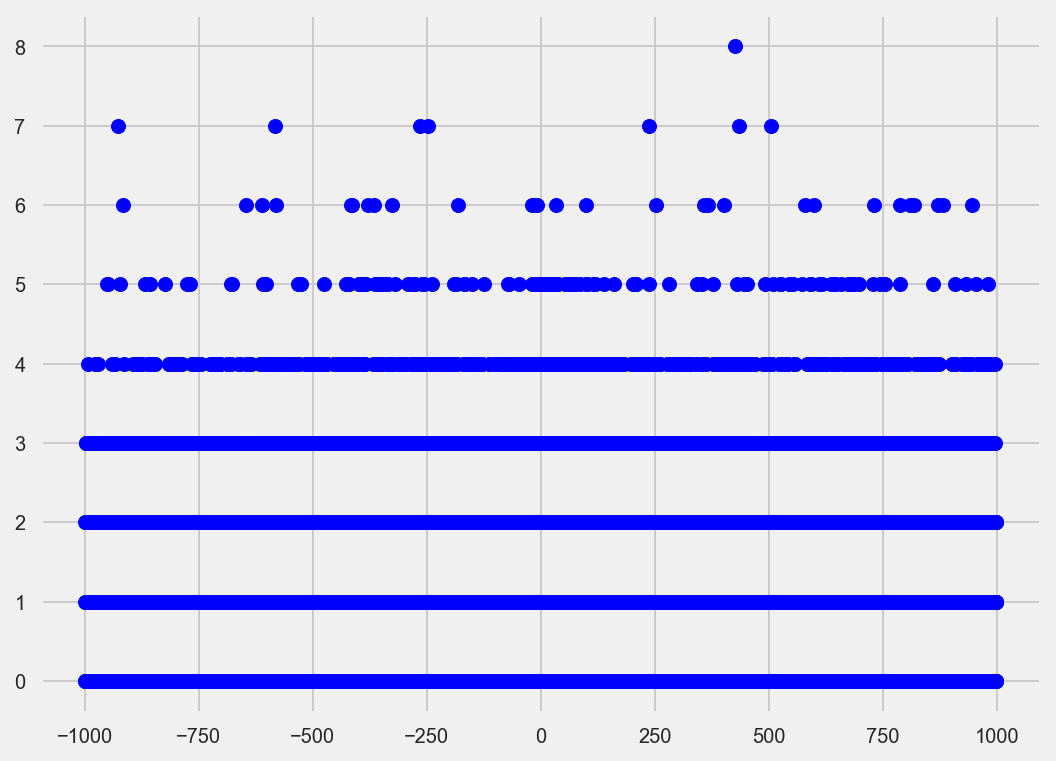

In [71]:
plt.scatter(anno_prom['Distance to TSS'],anno_prom['TATA instances'])

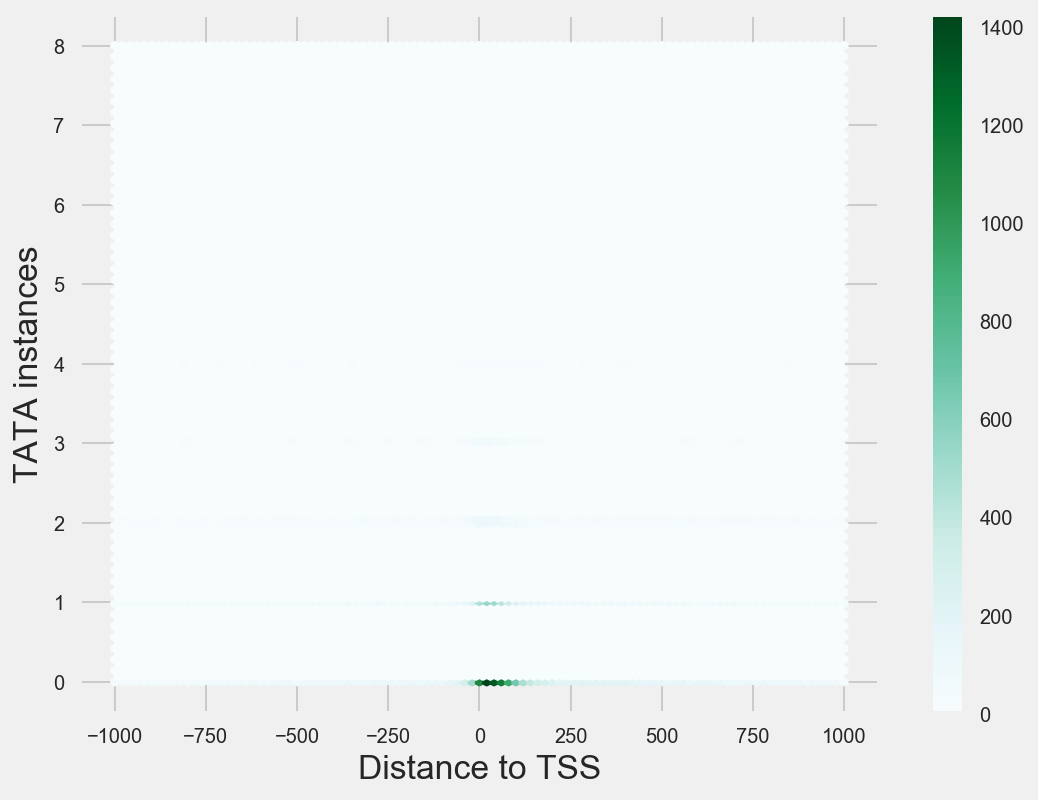

In [72]:
anno_prom.plot.hexbin(x='Distance to TSS',y='TATA instances',gridsize=100)

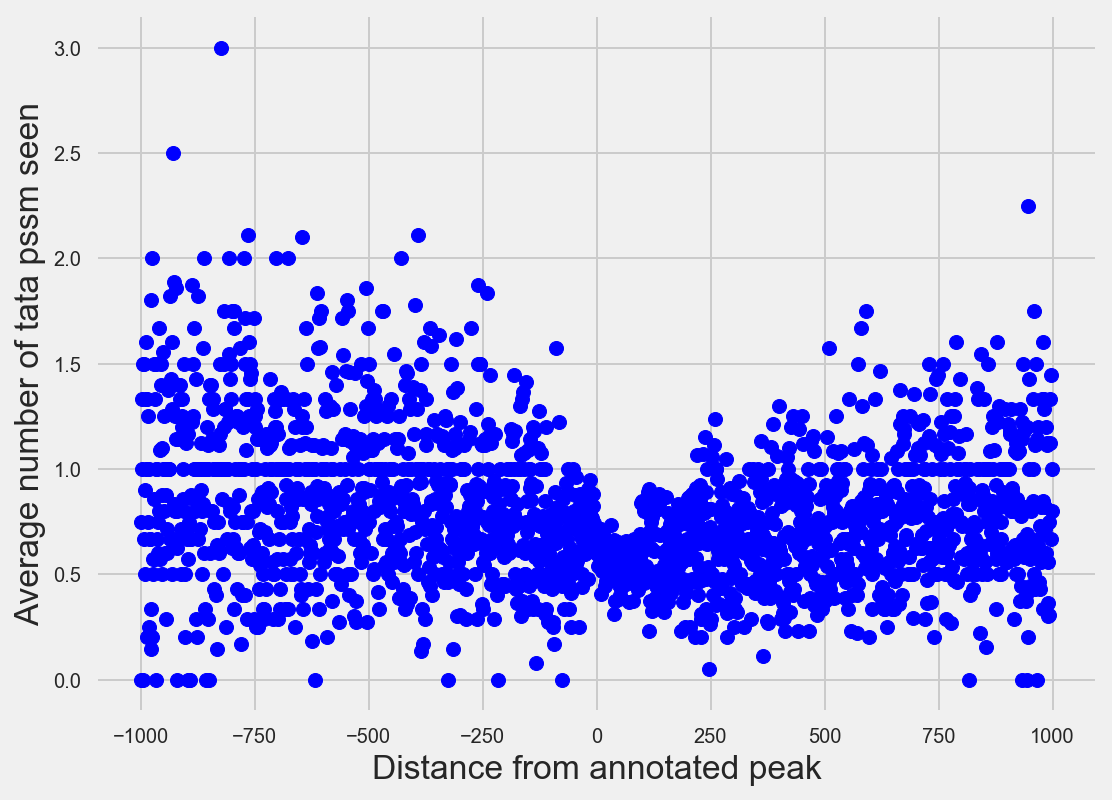

In [74]:
curr = (anno_prom.groupby(['Distance to TSS']).mean()['TATA instances'])
plt.scatter(curr.index,curr)
plt.ylabel("Average number of tata pssm seen")
plt.xlabel('Distance from annotated peak')
plt.savefig('Results/Figures/motifs_tata_instances_promoter_mean_across.png')

----

### Scores
#### Create dataframe of -75 to +75

In [7]:
i = 'tata'
f_out = 'Results/motifs/promoter_1kb_1kb' + i + '.p'

motifs = pickle.load(open(f_out,'rb'))
print(len(motifs))

In [9]:
#### Average len of seqs
avg_len = [] #np.infty(len(motifs))
for key in motifs:
    avg_len.append(len(motifs[key]))
    
print(np.mean(avg_len))
print(np.median(avg_len))

181.173211106
158.0


In [10]:
print('Number less than 150 bp',np.sum(np.array(avg_len)<150))
print('Number less than 50 bp',np.sum(np.array(avg_len)<50))
print('Average length: ',len(avg_len))
      


('Number less than 150 bp', 15732)
('Number less than 50 bp', 10)
('Average length: ', 34253)


In [12]:
%%time
tata_position = pd.DataFrame(columns=np.arange(-75,75))
tata_max = dict()
for key in tqdm.tqdm(motifs):
    val = motifs[key]
    center = int(np.floor(len(val)/2)) + 1 
    l = len(val)
    if l < 150:
        ## If less, need to reorient towards the center
        start = -75+int(np.ceil((150-l)/2)) #Determine the starting column by dividing the empty vals to the left and right
        end = start + l
        match = np.arange(start,end)
        d = dict()
        for i in range(len(match)):
            d[match[i]] = val[i]
        tata_position = tata_position.append(pd.DataFrame(d,index=[key]))    
    elif l >= 150: 
        start_ind = np.floor((l - 150)/2) #this is the starting index to keep from the val vector
        end_ind = start_ind+150
        curr = pd.DataFrame(val[int(start_ind):int(end_ind)],columns=[key]).transpose()
        cols = np.arange(-75,75)
        curr.columns = cols
        tata_position = tata_position.append(curr)
        
    tata_max[key] = max(motifs[key])
        

## Pickle
pickle.dump(tata_max,open('Results/motifs/tata_max_1kb_1kb.p','wb'))
## position
tata_position.to_csv('Results/motifs/tata_position_1kb_1kb.csv')

100%|██████████| 34253/34253 [10:51<00:00, 52.54it/s]


CPU times: user 9min 7s, sys: 1min 46s, total: 10min 53s
Wall time: 10min 58s


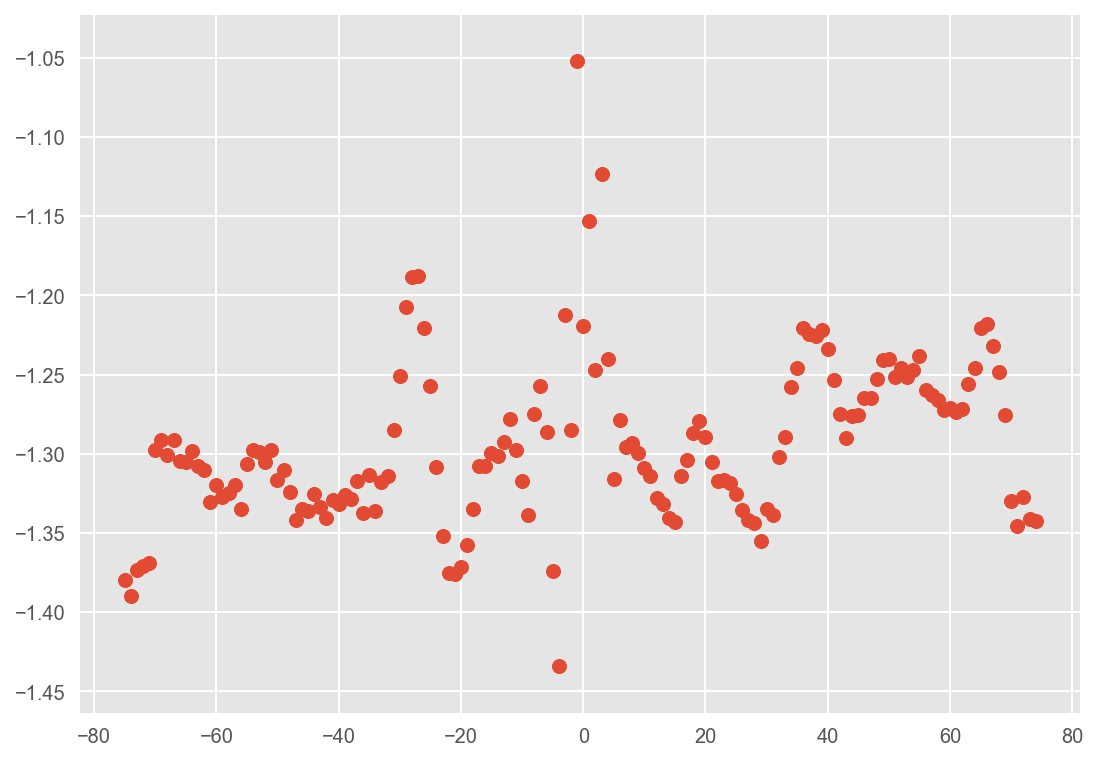

In [13]:
plt.scatter(x=np.arange(-75,75),y=np.nanmean(tata_position,axis=0))

In [16]:
anno_prom = anno_peaks[anno_peaks.index.isin(tata_max.keys())]
anno_prom['tata max score'] = pd.Series(tata_max)

# for key in tqdm.tqdm(tata_max):
#     anno_prom.loc[key,'tata max score'] = tata_max[key]

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


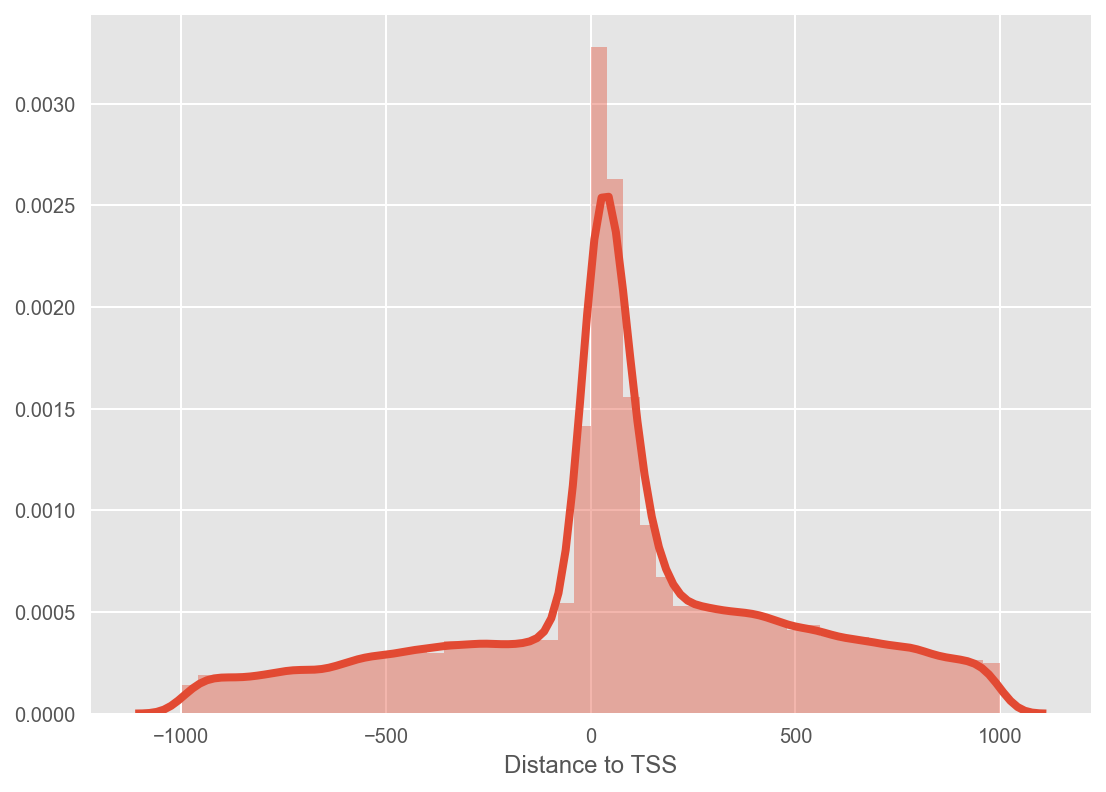

In [18]:
sns.distplot(anno_prom['Distance to TSS'])

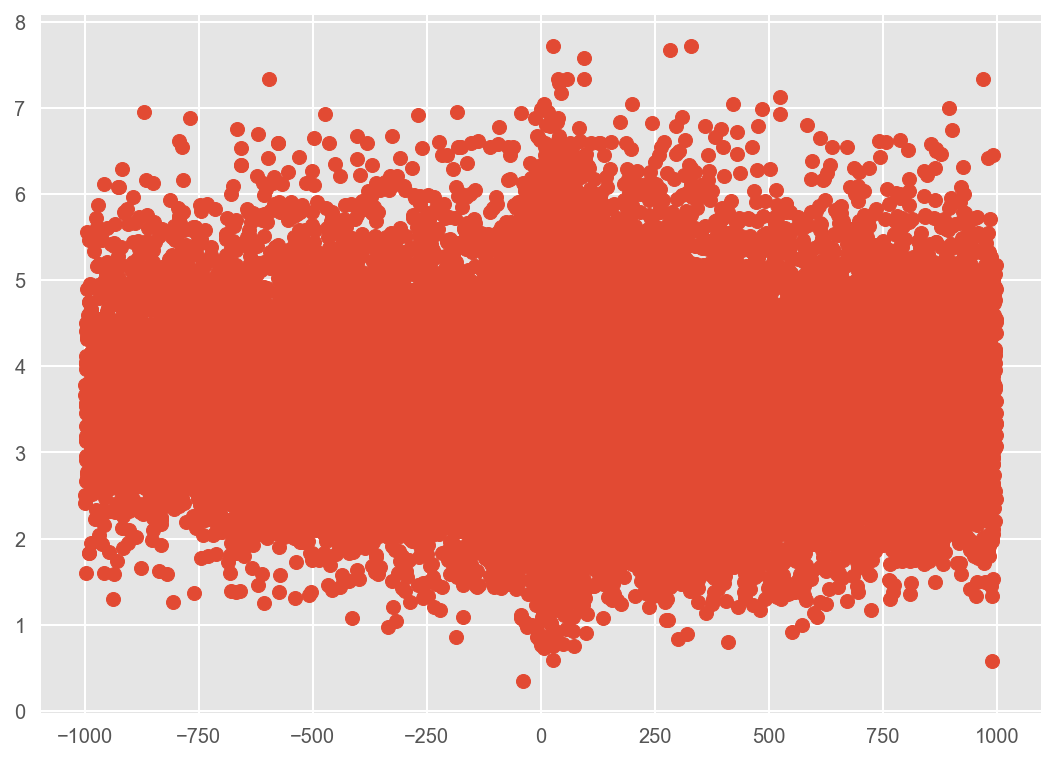

In [20]:
plt.scatter(anno_prom['Distance to TSS'],anno_prom['tata max score'])

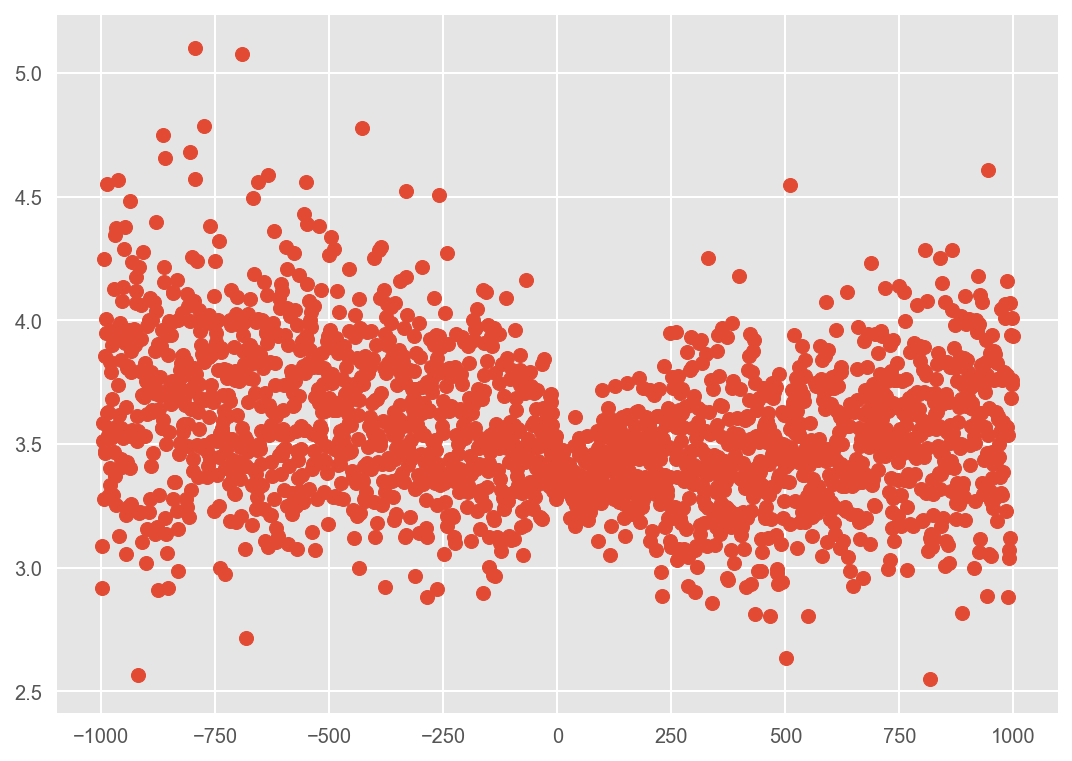

In [36]:
curr = (anno_prom.groupby(['Distance to TSS']).mean()['tata max score'])
plt.scatter(curr.index,curr)

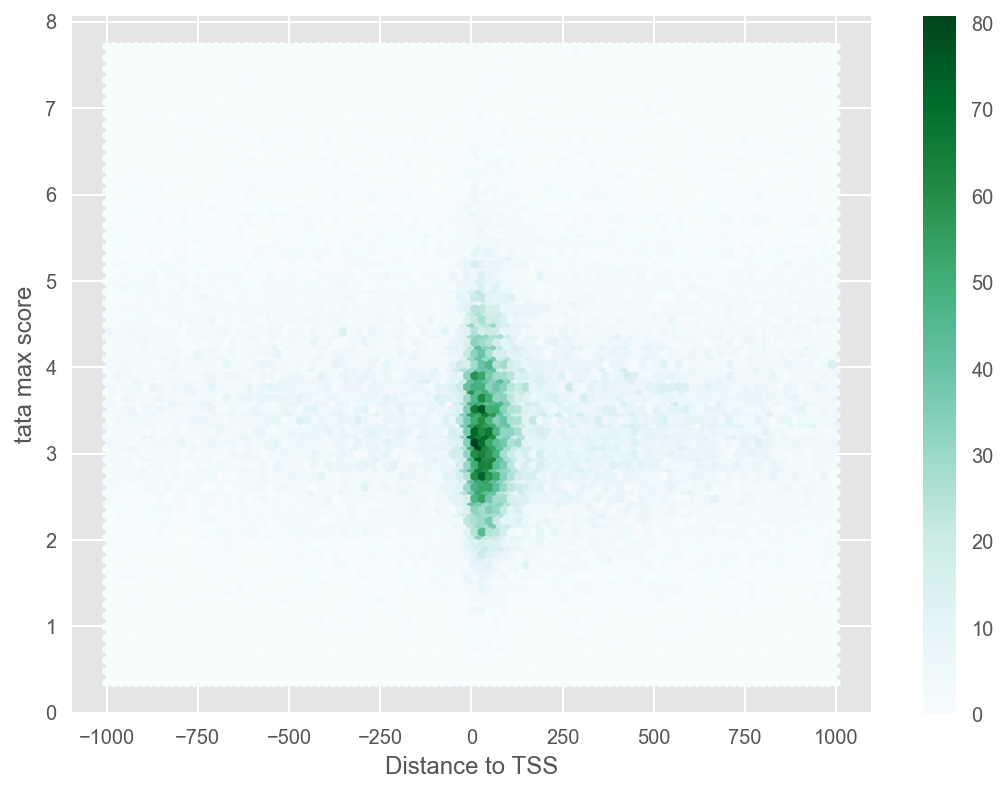

In [26]:
anno_prom.plot.hexbin(x='Distance to TSS',y='tata max score',gridsize=100)

## TATA with all peaks

In [50]:
i = 'tata'
f_out = 'Results/motifs/duplicateSeparate_peaks_merged_anno' + i + '.p'

motifs = pickle.load(open(f_out,'rb'))
print(len(motifs))

#### Average len of seqs
avg_len = [] #np.infty(len(motifs))
for key in motifs:
    avg_len.append(len(motifs[key]))
    
    
print('Number less than 150 bp',np.sum(np.array(avg_len)<150))
print('Number less than 50 bp',np.sum(np.array(avg_len)<50))
print('Average length: ',np.mean(avg_len))
print('Median length: ',(np.median(avg_len)))
  


470183
('Number less than 150 bp', 352843)
('Number less than 50 bp', 581)
('Average length: ', 157.88663562910611)
('Median length: ', 140.0)


In [48]:
np.mean(avg_len)

157.88663562910611

In [12]:
%%time
tata_position = pd.DataFrame(columns=np.arange(-75,75))
tata_max = dict()
for key in tqdm.tqdm(motifs):
    val = motifs[key]
    center = int(np.floor(len(val)/2)) + 1 
    l = len(val)
    if l < 150:
        ## If less, need to reorient towards the center
        start = -75+int(np.ceil((150-l)/2)) #Determine the starting column by dividing the empty vals to the left and right
        end = start + l
        match = np.arange(start,end)
        d = dict()
        for i in range(len(match)):
            d[match[i]] = val[i]
        tata_position = tata_position.append(pd.DataFrame(d,index=[key]))    
    elif l >= 150: 
        start_ind = np.floor((l - 150)/2) #this is the starting index to keep from the val vector
        end_ind = start_ind+150
        curr = pd.DataFrame(val[int(start_ind):int(end_ind)],columns=[key]).transpose()
        cols = np.arange(-75,75)
        curr.columns = cols
        tata_position = tata_position.append(curr)
        
    tata_max[key] = max(motifs[key])
        

## Pickle
pickle.dump(tata_max,open('Results/motifs/tata_max_1kb_1kb.p','wb'))
## position
tata_position.to_csv('Results/motifs/tata_position_1kb_1kb.csv')

100%|██████████| 34253/34253 [10:51<00:00, 52.54it/s]


CPU times: user 9min 7s, sys: 1min 46s, total: 10min 53s
Wall time: 10min 58s


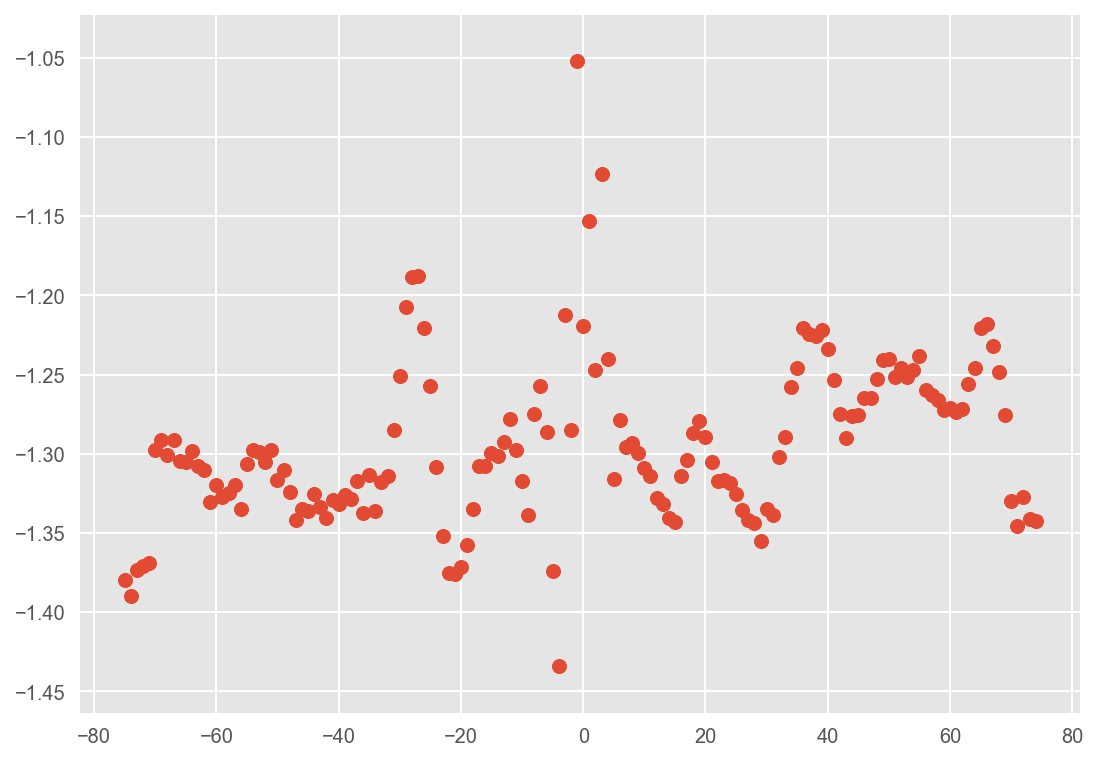

In [13]:
plt.scatter(x=np.arange(-75,75),y=np.nanmean(tata_position,axis=0))

In [16]:
anno_prom = anno_peaks[anno_peaks.index.isin(tata_max.keys())]
anno_prom['tata max score'] = pd.Series(tata_max)

# for key in tqdm.tqdm(tata_max):
#     anno_prom.loc[key,'tata max score'] = tata_max[key]

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


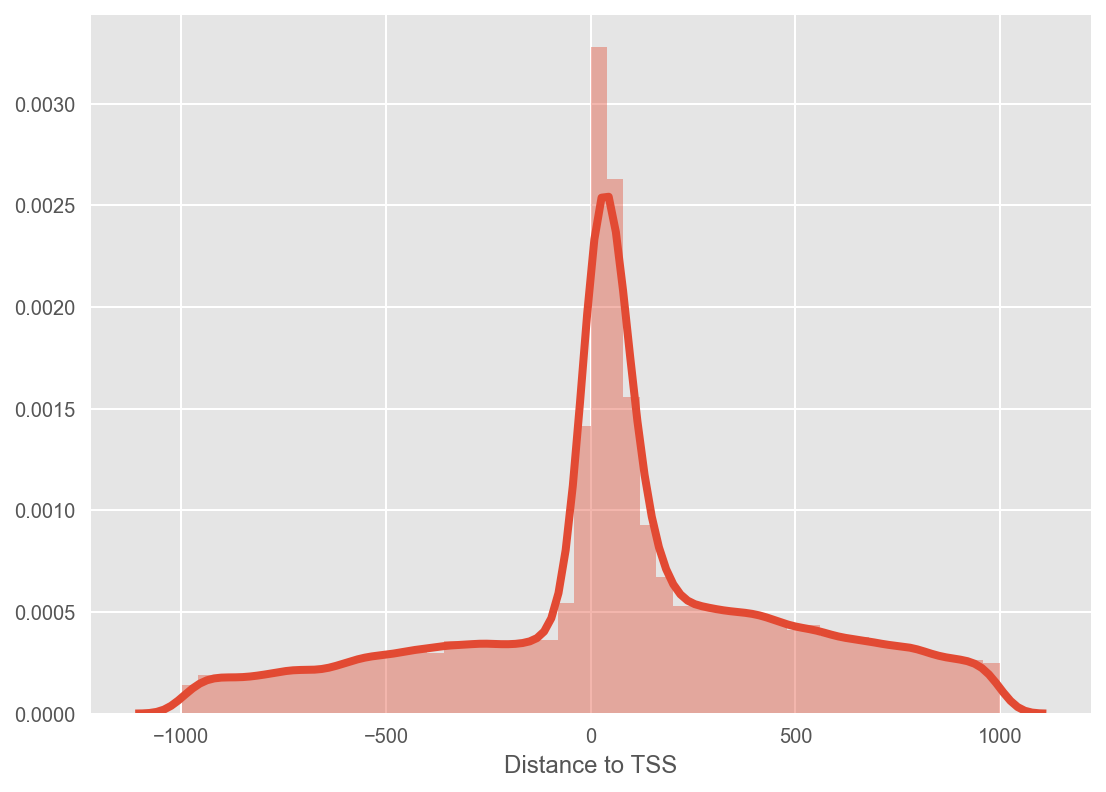

In [18]:
sns.distplot(anno_prom['Distance to TSS'])

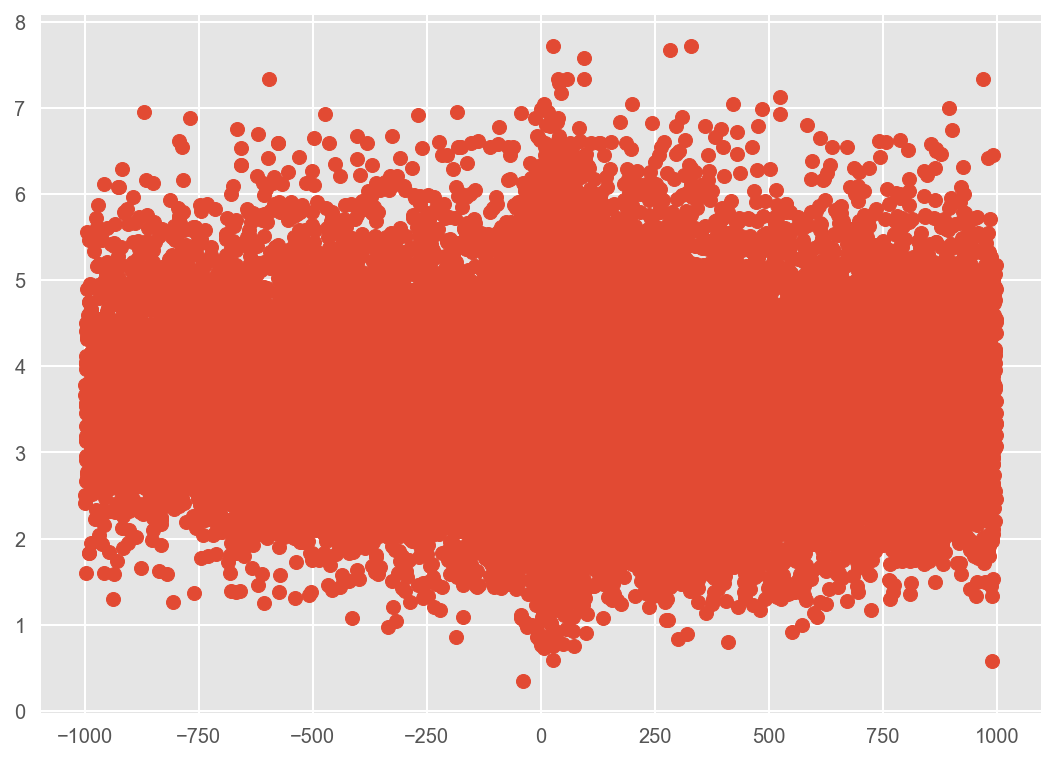

In [20]:
plt.scatter(anno_prom['Distance to TSS'],anno_prom['tata max score'])

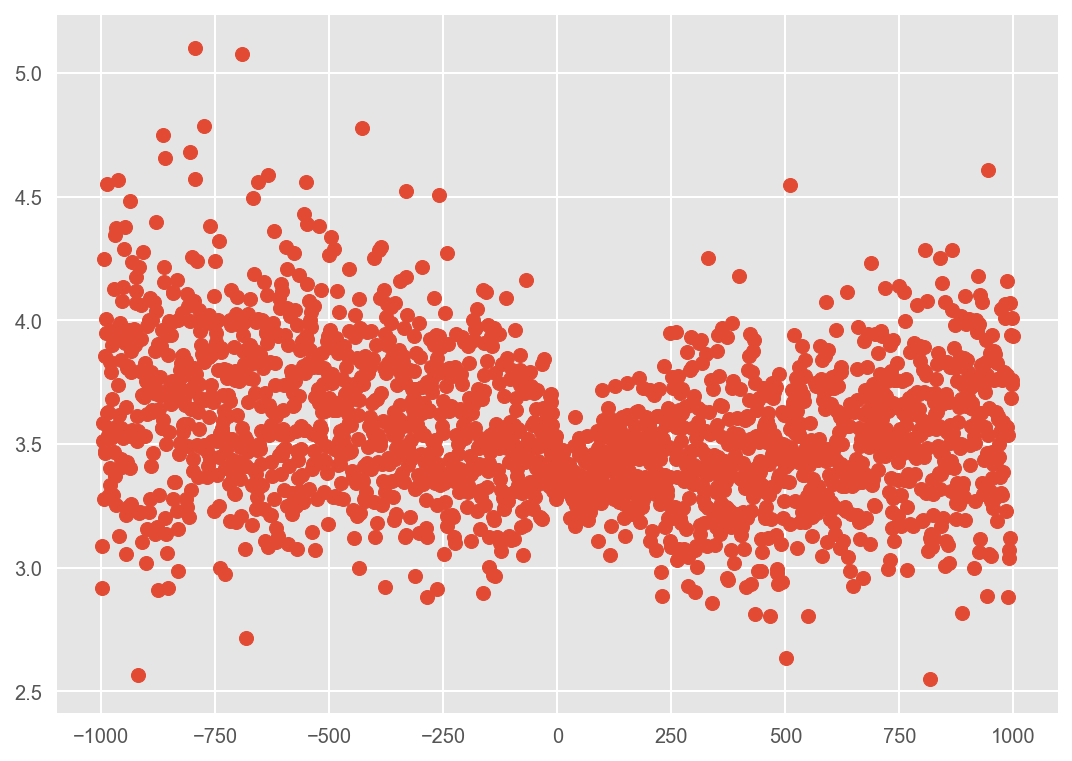

In [36]:
curr = (anno_prom.groupby(['Distance to TSS']).mean()['tata max score'])
plt.scatter(curr.index,curr)

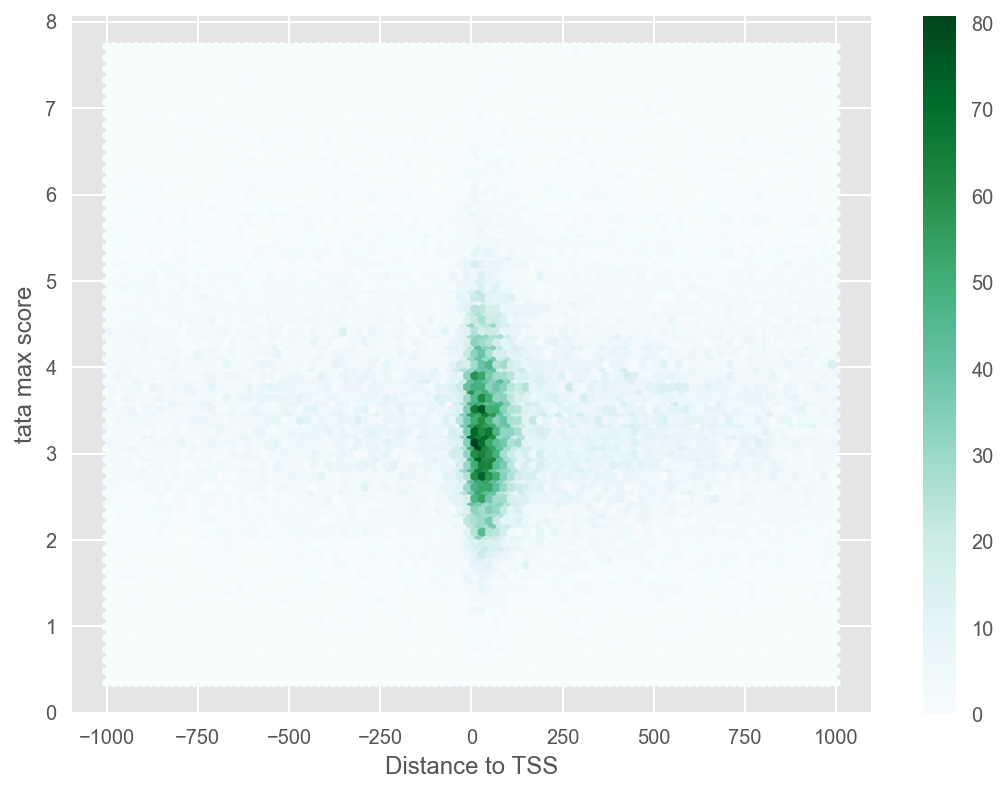

In [26]:
anno_prom.plot.hexbin(x='Distance to TSS',y='tata max score',gridsize=100)